Кластеризация может быть определена как задача группировки набора объектов таким образом, чтобы объекты в одной группе (называемой кластером) были более похожи друг на друга, чем на объекты в других группах (кластерах).

Кластеризация Бутина (J. Chem. Inf. Model. (1999) был разработан для идентификации меньших, но однородных кластеров с условием, что (по крайней мере) центроид кластера будет более похож, чем заданный порог, на любую другую молекулу в кластере.
Для выявления химического сходства соединения во входных данных (например, предоставленных как SMILES) будут закодированы как молекулярные "отпечатки пальцев"(fingerprints), например, RDK5 fingerprint, который представляет собой fingerprint на основе субграфа, похожий на хорошо известный daylight Fingerprint (который использовался в оригинальной публикации).
Матрица сходства (расстояний) между двумя fingerprints рассчитывается с использованием коэффициента Танимото.

Молекулы будут сгруппированы вместе, если они имеют максимальное расстояние ниже указанной отсечки от центроида кластера (если используется матрица расстояний) или если они имеют минимальное сходство выше указанной границы (если используется матрица сходства).

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

# Подготовка данных:
def ClusterFps(fps,cutoff=0.2):
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # генерация матрицы расстояний:
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # кластеризация данных:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs

In [2]:
# Импортируем файл датасета, содержащий все полученные молекулы с их SMILES формулами.
ms = [x for x in Chem.SDMolSupplier('test_molecules_edited_2.sdf',removeHs=False)] 
len(ms)  # Для кластеризации будут использованы все имеющиеся 305 молекул. 

305

In [3]:
# SMILES-формулы будут закодированы как молекулярные fingerprints.
fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in ms]
print("Number of compounds converted:", len(fps))
print("Fingerprint length per compound:", len(fps[0]))

Number of compounds converted: 305
Fingerprint length per compound: 1024


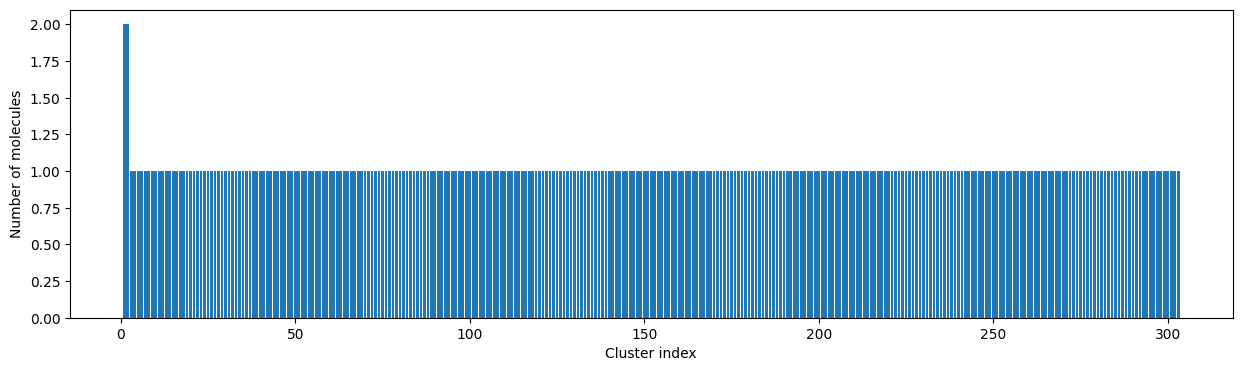

In [5]:
# Посмотрим на размеры кластеров для дальнейшей установки отсечки:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);

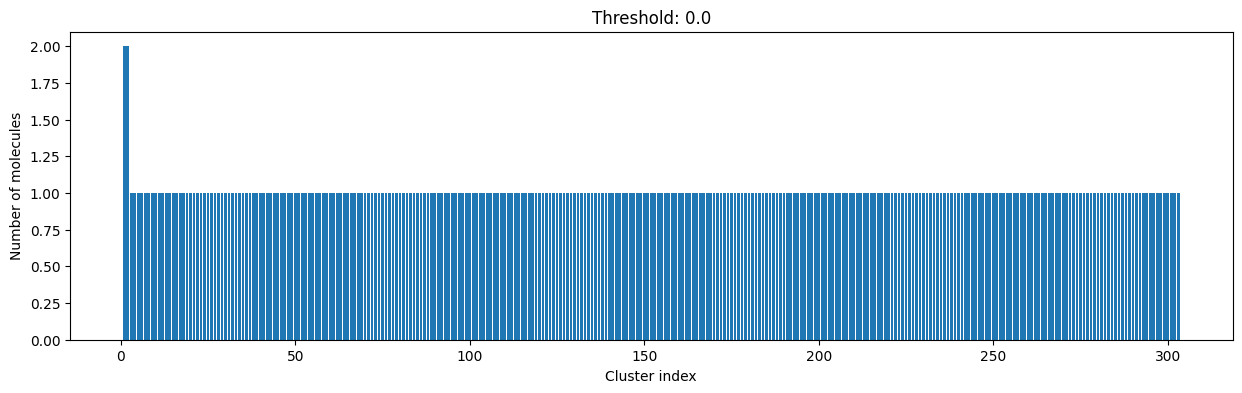

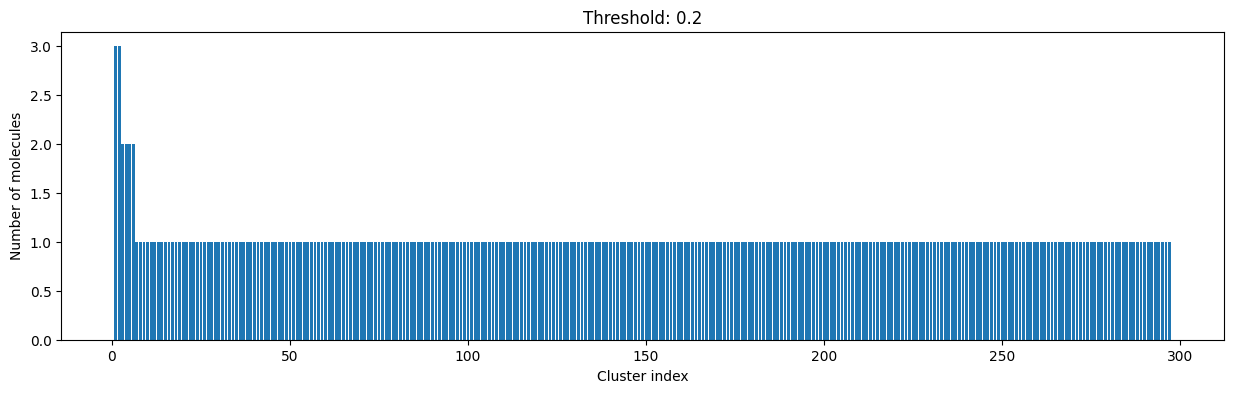

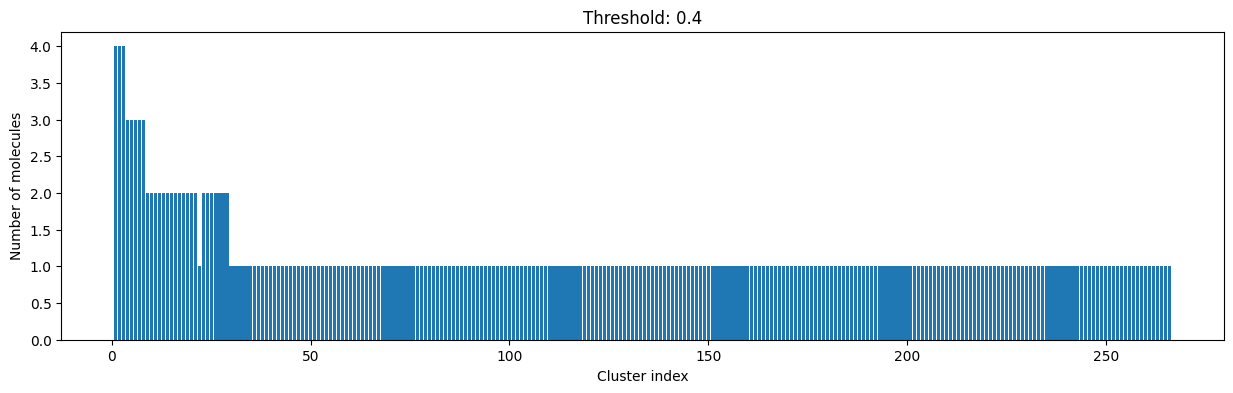

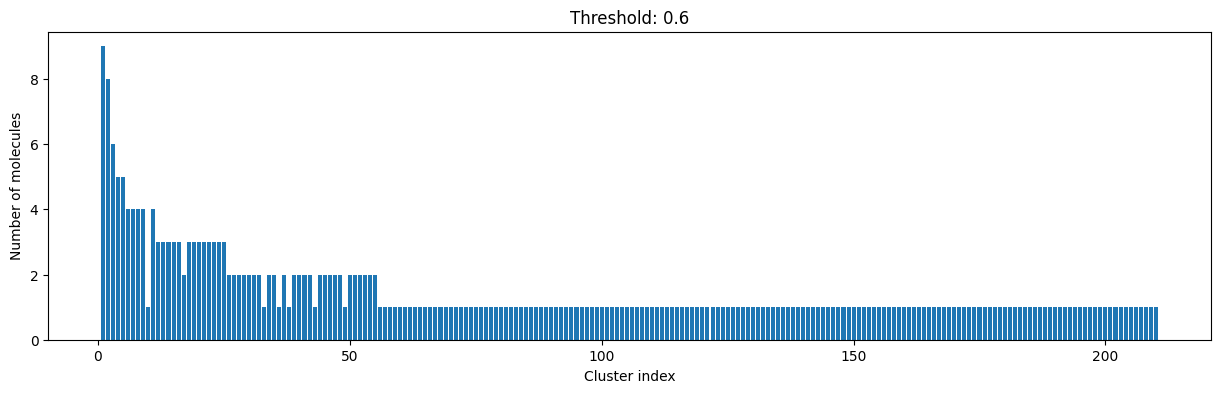

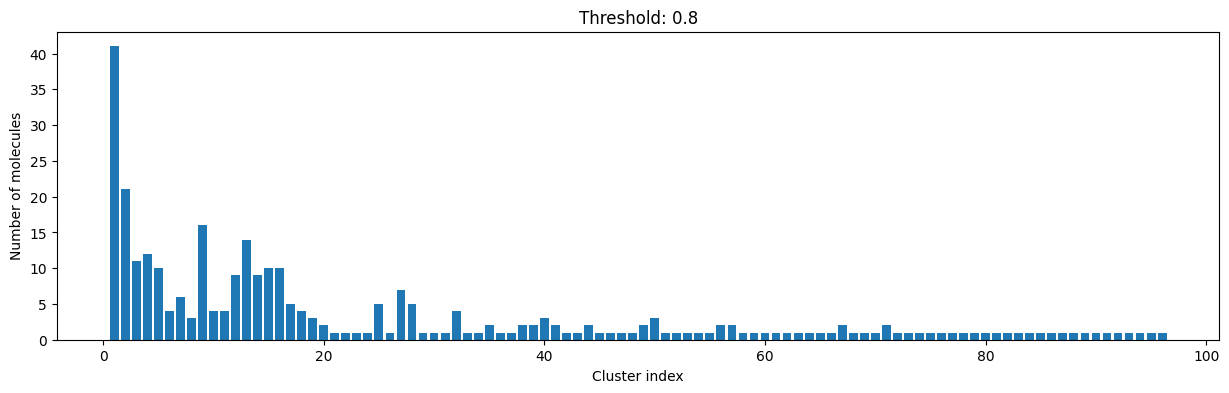

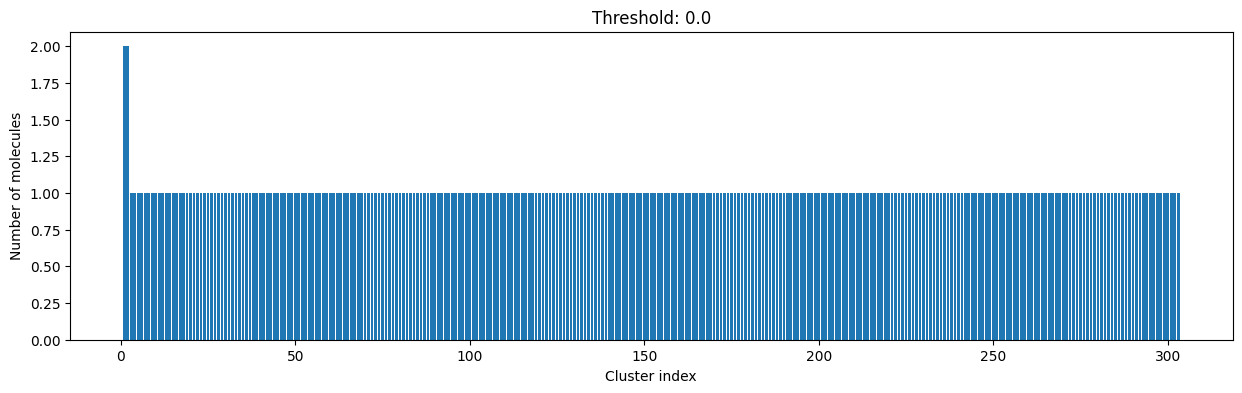

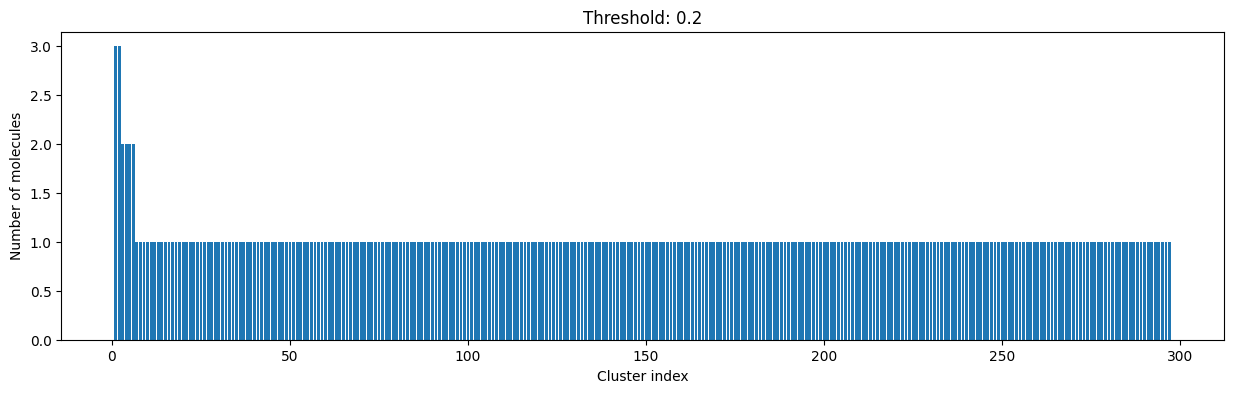

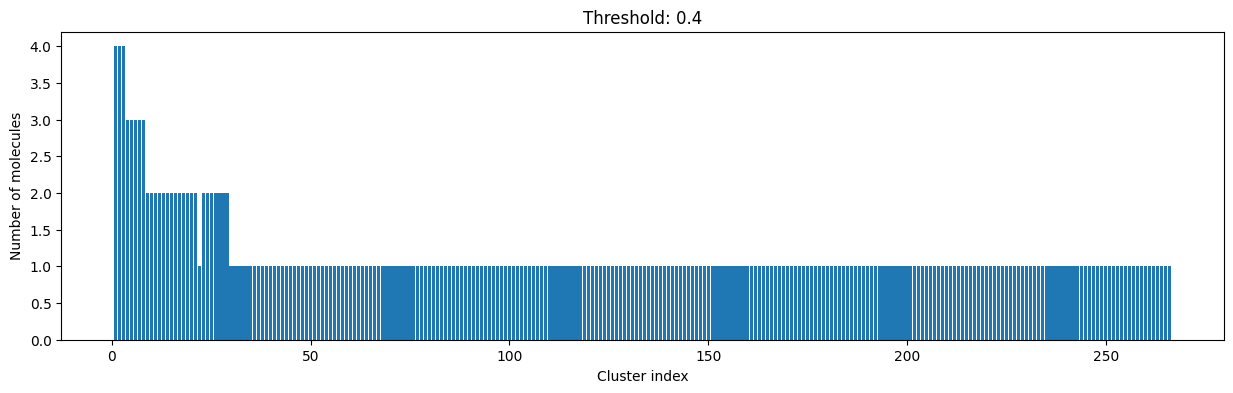

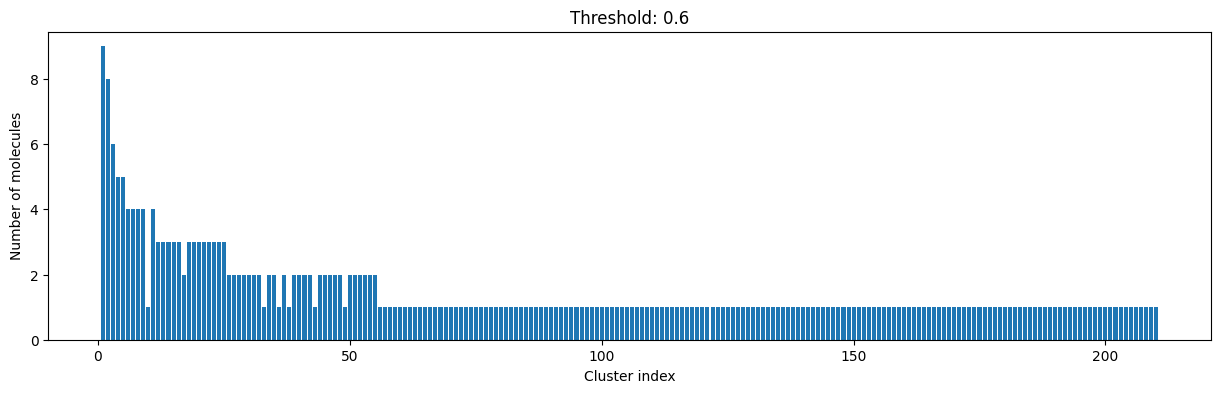

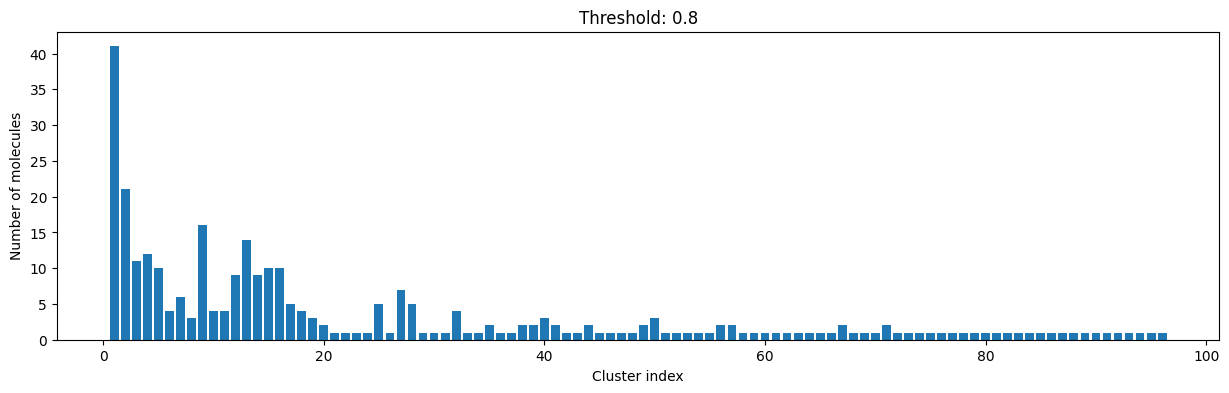

In [6]:
# Рассмотрим класстеры с разными настройками отсечки: 
import numpy as np
for cutoff in np.arange(0.0, 1.0, 0.2):
    clusters = ClusterFps(fps, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    display(fig)

- Чем выше порог (отсечение расстояния), тем больше молекул считаются похожими и, следовательно, группируются в меньшее количество кластеров. 
- Чем ниже порог, тем больше мелких кластеров. 
- Чем меньше отсечка значения расстояния, тем более похожими должны быть соединения, чтобы принадлежать к одному кластеру.

На основе построенных выше диаграмм в пользу выбора порога расстояния 0.6 свидетельствует более плавное распределение кластеров и меньшее количество синглтонов: 

In [14]:
clusters=ClusterFps(fps,cutoff=0.6) 
len(clusters)  # Количество кластеров. 

210

In [16]:
len(clusters[0])  # Количество молекул в самом большом кластере:

9

(39, 181, 182, 203, 213, 214, 219, 233, 301)


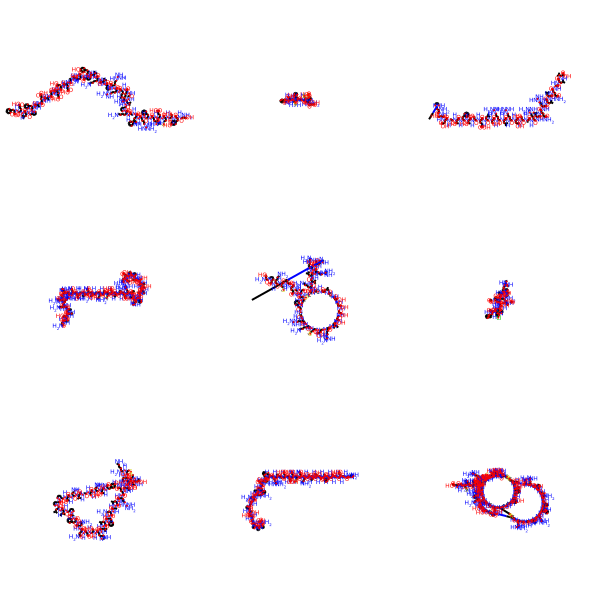

In [19]:
print(clusters[0]) # Вывод индексов молекул одного из кластеров по индексу кластера


# Визуализация молекул для одного из кластеров, m1, m2, m3, m4 - индексы молекул
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

m1 = ms[39]
m2 = ms[181]
m3 = ms[182]
m4 = ms[203]
m5 = ms[213]
m6 = ms[214]
m7 = ms[219]
m8 = ms[233]
m9 = ms[301]

mols=(m1,m2,m3,m4, m5, m6, m7, m8, m9)
Draw.MolsToGridImage(mols)

(256, 51, 121)


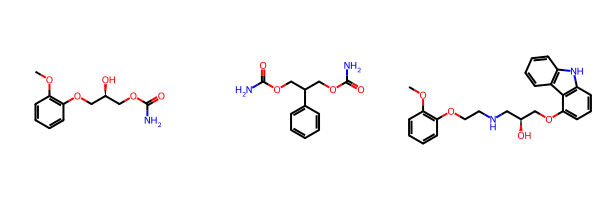

In [21]:
print(clusters[12]) # Вывод индексов молекул одного из кластеров по индексу кластера


# Визуализация молекул для одного из кластеров, m1, m2, m3, m4 - индексы молекул
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

m1 = ms[256]
m2 = ms[51]
m3 = ms[121]
mols=(m1,m2, m3)
Draw.MolsToGridImage(mols)

Идентификация потенциальных центроидов кластера:
- Центроид кластера — это молекула в данном кластере, которая имеет наибольшее количество соседей.
- Для каждой молекулы подсчитываются все молекулы с расстоянием Танимото ниже заданного порога.
- Сортировка молекул по количеству их соседей происходит в порядке убывания, так что потенциальные центроиды кластера (то есть соединения с наибольшим количеством соседей) размещаются в верхней части файла, т.е. обладают меньшим значением индекса кластера. 